In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import scipy.stats as stats

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window

from utils import *

pio.renderers.default = "iframe"

In [7]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

In [8]:
base_path = "/data/saturation/thesis_run_20240130/"

r_stat = 5
study_region_width = 2000
study_region_size = study_region_width ** 2 / r_stat ** 2

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10(F.col("n_craters_added_in_study_region")).alias("log_n_craters_added_in_study_region"),
    F.log10("areal_density").alias("log_ad"),
)

In [10]:
target = "n_craters_added_in_study_region"
predictor_variables = [
    "slope",
    "r_stat_multiplier",
    "effective_radius_multiplier",
    "min_rim_percentage",
    "log_mean_c2c_nn_dist",
    "areal_density",
    "log_ad",
    "n_craters_added_in_study_region",
    "n_craters_in_study_region",
    "data.simulation_id",
    "log_n_craters_added_in_study_region"
]

In [58]:
# Get all craters within some bandwidth using slope, log(NN_d), and log(A_d)
train_sample_fraction = 0.8
n_test_samples = 0

data_subset = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(50))
)

train, _ = setup_datasets_for_model(
    data_subset,
    configs_df,
    0.1,
    predictor_variables,
    target,
    train_sample_fraction,
    n_test_samples,
    spark,
    cache_train=False,
    cache_test=False
)
train = train.where(train.slope.between(2.1, 2.2)).cache()

In [51]:
# It appears that the sample size needs to be pretty low for this to work
pre_start = 1.1
pre_step = 0.00025

pre_saturation1 = train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start, pre_start + pre_step * 1))
).toPandas()

pre_saturation2 = train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start + pre_step * 1, pre_start + pre_step * 2))
).toPandas()

pre_saturation3 = train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start + pre_step * 50, pre_start + pre_step * 51))
).toPandas()

post_saturation1 = train.where(
    (train.log_mean_c2c_nn_dist.between(.8, .8 + pre_step))
).toPandas()

post_saturation2 = train.where(
    (train.log_mean_c2c_nn_dist.between(.7, .7 + pre_step))
).toPandas()

In [14]:
def get_middle_n_samples(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    return df.iloc[(df.shape[0] - n_samples) // 2:(df.shape[0] + n_samples) // 2]

In [44]:
# It appears that the sample size needs to be pretty low for this to work
pre_start = 1.2
pre_step = 0.0025
n_samples = 300

pre_saturation1 = get_middle_n_samples(train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start, pre_start + pre_step * 1))
).orderBy("log_mean_c2c_nn_dist").toPandas(), n_samples)

pre_saturation2 = get_middle_n_samples(train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start + pre_step * 1, pre_start + pre_step * 2))
).orderBy("log_mean_c2c_nn_dist").toPandas(), n_samples)

pre_saturation3 = get_middle_n_samples(train.where(
    (train.log_mean_c2c_nn_dist.between(pre_start + pre_step * 20, pre_start + pre_step * 21))
).orderBy("log_mean_c2c_nn_dist").toPandas(), n_samples)

post_saturation1 = get_middle_n_samples(train.where(
    (train.log_mean_c2c_nn_dist.between(.8, .8 + pre_step))
).orderBy("log_mean_c2c_nn_dist").toPandas(), n_samples)

post_saturation2 = get_middle_n_samples(train.where(
    (train.log_mean_c2c_nn_dist.between(.7, .7 + pre_step))
).orderBy("log_mean_c2c_nn_dist").toPandas(), n_samples)

In [57]:
print(pre_saturation1.shape)
print(pre_saturation2.shape)
print(pre_saturation3.shape)
print(post_saturation1.shape)
print(post_saturation2.shape)

(637, 13)
(626, 13)
(527, 13)
(17175, 13)
(16725, 13)


In [52]:
stats.levene(
    np.log10(post_saturation1.target),
    np.log10(post_saturation2.target)
)

LeveneResult(statistic=62.28061605711827, pvalue=3.0675443773481795e-15)

In [53]:
stats.levene(
    np.log10(pre_saturation1.target),
    np.log10(post_saturation1.target)
)

LeveneResult(statistic=812.8495268401654, pvalue=7.20220438574892e-175)

In [54]:
stats.levene(
    np.log10(pre_saturation1.target),
    np.log10(pre_saturation2.target)
)

LeveneResult(statistic=0.08537643838472901, pvalue=0.7701875351314944)

In [55]:
stats.levene(
    np.log10(pre_saturation2.target),
    np.log10(pre_saturation3.target)
)

LeveneResult(statistic=11.231057221730772, pvalue=0.0008305151275261495)

In [56]:
stats.levene(
    np.log10(pre_saturation1.target),
    np.log10(pre_saturation3.target)
)

LeveneResult(statistic=9.457026364147845, pvalue=0.002152526215898851)

## Algo for using F test

Given:
- Observed NN_d, observed slope
- Filter simulation data points to a given range of slope, centered on observed slope
- Find the point of saturation from the sim data by:
   - Comparing regions < observed NN_d to > NN_d
   - Grow the "right" hand region until F test rejects the null
   - Grow by the CI interval of log(NN_d)
- Result: a "right" region that is not saturated, right region is approaching saturation
- Now calculate two 95% CIs:
  - One for the "neighborhood" of the observed surface
  - One for the region to the left in the graph (onset of saturation)


(array([1.9000e+01, 1.3400e+02, 5.3800e+02, 7.1040e+03, 4.8323e+04,
        7.7593e+04, 2.1927e+04, 2.0820e+03, 2.2800e+02, 7.1000e+01]),
 array([-0.25022311, -0.20265405, -0.15508498, -0.10751592, -0.05994686,
        -0.01237779,  0.03519127,  0.08276033,  0.1303294 ,  0.17789846,
         0.22546752]),
 <BarContainer object of 10 artists>)

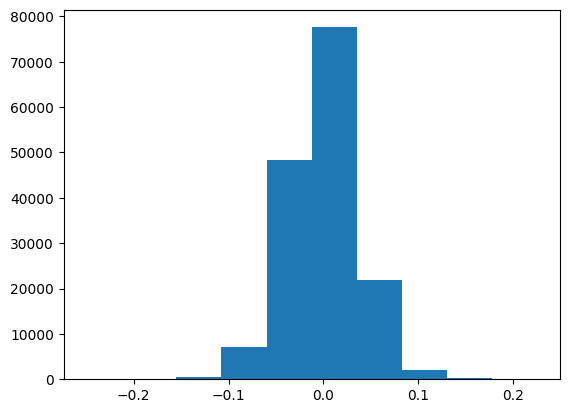

In [99]:
# Obs: slope=2.15, nn_d = 1.1
obs_nnd = 1.1

train = train.where(train.slope.between(2.1, 2.2))
d = train.where(
    # (train.log_mean_c2c_nn_dist.between(1.1, 1.5))
    (train.log_mean_c2c_nn_dist.between(1.1, 1.2))
).orderBy("log_mean_c2c_nn_dist").toPandas()

s1 = d.log_n_craters_added_in_study_region
s1 = s1.diff().dropna()
plt.hist(s1)

(array([ 23152.,  45640.,  38657.,  51011., 393120., 349627.,  49334.,
         38809.,  45725.,  21641.]),
 array([-1.103928  , -0.88228015, -0.6606323 , -0.43898446, -0.21733661,
         0.00431124,  0.22595908,  0.44760693,  0.66925478,  0.89090262,
         1.11255047]),
 <BarContainer object of 10 artists>)

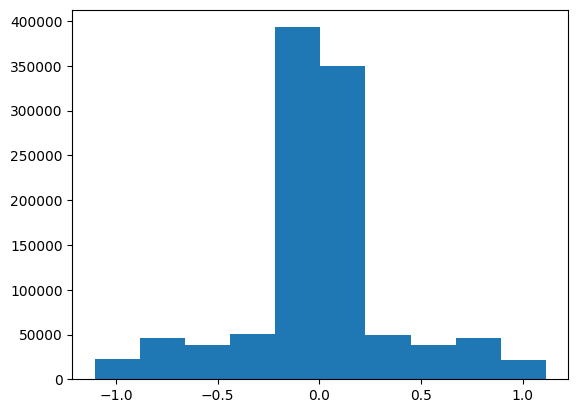

In [92]:
# Obs: slope=2.15, nn_d = 1.1
obs_nnd = 1.0

train = train.where(train.slope.between(2.1, 2.2))
d = train.where(
    (train.log_mean_c2c_nn_dist.between(0.9, 1.1))
).orderBy("log_mean_c2c_nn_dist").toPandas()

s2 = d.log_n_craters_added_in_study_region
s2 = s2.diff().dropna()
plt.hist(s2)

(array([110033., 270523., 314694., 408151., 672687., 659654., 405240.,
        313335., 269570., 106532.]),
 array([-1.09192626, -0.87316918, -0.65441209, -0.43565501, -0.21689793,
         0.00185915,  0.22061623,  0.43937331,  0.65813039,  0.87688747,
         1.09564455]),
 <BarContainer object of 10 artists>)

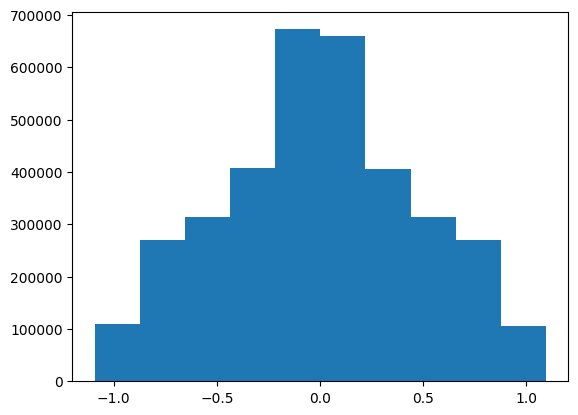

In [104]:
# Obs: slope=2.15, nn_d = 1.1
train = train.where(train.slope.between(2.1, 2.2))
d = train.where(
    (train.log_mean_c2c_nn_dist.between(0.8, 0.9))
).orderBy("log_mean_c2c_nn_dist").toPandas()

s2 = d.log_n_craters_added_in_study_region
s2 = s2.diff().dropna()
plt.hist(s2)

In [101]:
s1.shape

(158019,)

In [102]:
s2.shape

(94935,)

In [105]:
p_value = 1 - stats.f.cdf(np.var(s2) / np.var(s1), s2.shape[0] - 1, s1.shape[0] - 1)
p_value

1.1102230246251565e-16

In [106]:
stats.levene(s1, s2)

LeveneResult(statistic=243802.8605534085, pvalue=0.0)

In [78]:
np.std(t.dropna())

0.0448006243142034

In [79]:
stats.kurtosis(t.dropna())

2.9593818065044175

In [80]:
stats.skew(t.dropna())

-0.0054644394208463575

In [120]:
import statsmodels.api as sm

In [139]:
t, _ = setup_datasets_for_model(
    data_subset,
    configs_df,
    0.1,
    predictor_variables,
    target,
    train_sample_fraction,
    n_test_samples,
    spark,
    cache_train=False,
    cache_test=False
)
train = t.where(train.slope.between(2.1, 2.2)).cache()
ds = train.where(
    (train.log_mean_c2c_nn_dist.between(1.0, 1.5))
).toPandas()

In [140]:
model = sm.OLS(ds.log_n_craters_added_in_study_region,
               sm.add_constant(ds.log_mean_c2c_nn_dist)).fit()

In [141]:
pred = model.predict(sm.add_constant(ds.log_mean_c2c_nn_dist))
ds["detrended"] = ds.log_n_craters_added_in_study_region - pred
ds["pred"] = pred

(array([1.80000e+01, 1.02000e+02, 1.64540e+04, 2.71103e+05, 2.70594e+05,
        6.43240e+04, 1.19970e+04, 2.61300e+03, 1.80900e+03, 1.08400e+03]),
 array([-0.18243684, -0.13903531, -0.09563379, -0.05223226, -0.00883074,
         0.03457079,  0.07797231,  0.12137384,  0.16477536,  0.20817689,
         0.25157841]),
 <BarContainer object of 10 artists>)

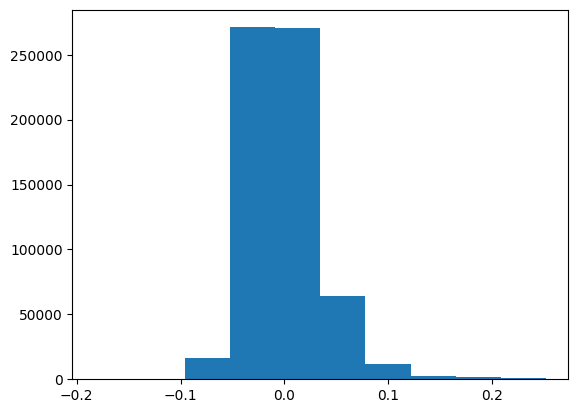

In [142]:
plt.hist(ds.detrended)

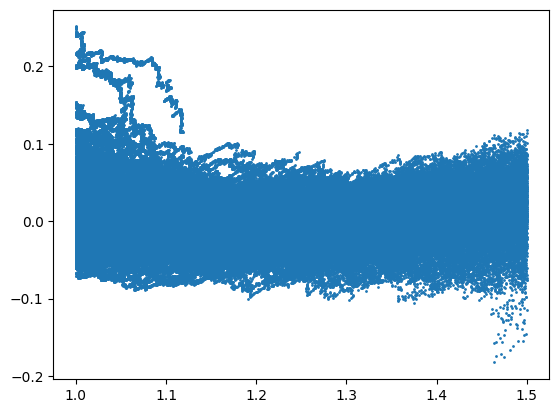

In [145]:
a = ds.sort_values("log_mean_c2c_nn_dist")
plt.scatter(a.log_mean_c2c_nn_dist, a.detrended, s=1)

In [147]:
stats.skew(a.detrended)

1.532977495157734

### Trying F test with detrended data

In [438]:
def detrend(x: pd.Series, y: pd.Series) -> pd.Series:
    model = sm.OLS(y, sm.add_constant(x)).fit()

    pred = model.predict(sm.add_constant(x))
    return y - pred

def f_test(sample1: pd.Series, sample2: pd.Series) -> float:
    var1 = np.var(sample1)
    df1 = sample1.shape[0] - 1
    var2 = np.var(sample2)
    df2 = sample2.shape[0] - 1
    
    numer, numer_df, denom, denom_df = (var1, df1, var2, df2) if var1 > var2 else (var2, df2, var1, df1)
    return 1 - stats.f.cdf(numer / denom, numer_df, denom_df)

def report(sample: pd.Series):
    variance = np.var(sample)
    skew = stats.skew(sample)
    kurtosis = stats.kurtosis(sample)
    print(f"var={variance}, skew={skew:.3f}, kurt={kurtosis:.3f}")

def remove_outliers(df: pd.DataFrame, series_name: str) -> pd.Series:
    """
    Removes entries outside 1.5 * iqr
    """
    series = df[series_name]
    lower = series.quantile(0.25)
    upper = series.quantile(0.75)
    iqr = upper - lower
    return df[series.between(lower - 1.5*iqr, upper + 1.5*iqr)]

In [173]:
t, _ = setup_datasets_for_model(
    data_subset,
    configs_df,
    0.1,
    predictor_variables,
    target,
    train_sample_fraction,
    n_test_samples,
    spark,
    cache_train=False,
    cache_test=False
)
train = t.where(train.slope.between(2.1, 2.2)).cache()

In [379]:
start_sample1 = 0.93
n_samples = 500

sample = train.where(
    train.log_mean_c2c_nn_dist > start_sample1
).orderBy("log_mean_c2c_nn_dist").limit(2 * n_samples).toPandas()
sample1 = sample.iloc[:n_samples]
sample2 = sample.iloc[n_samples:]
sample1_detrended = detrend(sample1.log_n_craters_added_in_study_region, sample1.log_mean_c2c_nn_dist)
sample2_detrended = detrend(sample2.log_n_craters_added_in_study_region, sample2.log_mean_c2c_nn_dist)

In [380]:
f_test(sample1_detrended, sample2_detrended)
report(sample1_detrended)
report(sample2_detrended)

0.33815008775208977

var=2.1907483586174625e-10, skew=-0.006, kurt=-1.240
var=2.1103253071109504e-10, skew=-0.196, kurt=-1.089


In [382]:
report(sample1_detrended)
report(sample2_detrended)

var=2.1907483586174625e-10, skew=-0.006, kurt=-1.240
var=2.1103253071109504e-10, skew=-0.196, kurt=-1.089


In [483]:
# Using n samples before and after a dividing point, with a delta
dividing_point = 1.25
delta = 0.05
n_new_samples = 1000

sample1 = train.where(
    train.log_mean_c2c_nn_dist.between(dividing_point, dividing_point + delta)
).withColumn(
    "rnd", F.rand()
).orderBy("rnd").limit(n_new_samples).toPandas()
sample1 = remove_outliers(sample1, "log_n_craters_added_in_study_region")

sample2 = train.where(
    train.log_mean_c2c_nn_dist.between(dividing_point - delta, dividing_point)
).withColumn(
    "rnd", F.rand()
).orderBy("rnd").limit(n_new_samples).toPandas()
sample2 = remove_outliers(sample2, "n_craters_added_in_study_region")

sample1_detrended = detrend(sample1.log_n_craters_added_in_study_region, sample1.log_mean_c2c_nn_dist)
sample2_detrended = detrend(sample2.log_n_craters_added_in_study_region, sample2.log_mean_c2c_nn_dist)

In [481]:
print(f_test(sample1_detrended, sample2_detrended))
report(sample1_detrended)
report(sample2_detrended)

0.04211204263418411
var=8.441111867403039e-05, skew=0.022, kurt=-0.263
var=7.566827665257148e-05, skew=-0.006, kurt=-0.030


In [482]:
stats.levene(sample1_detrended, sample2_detrended)

LeveneResult(statistic=4.500038196852726, pvalue=0.03401697591895144)

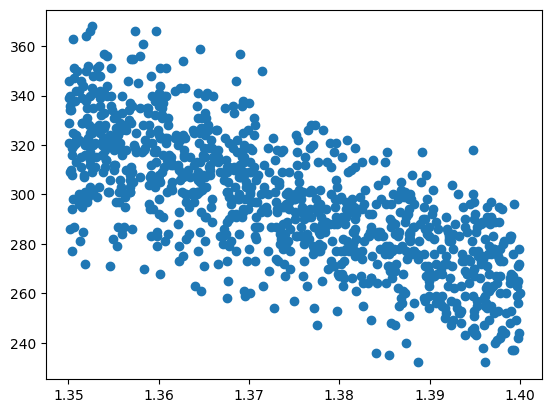

In [475]:
plt.scatter(sample1.log_mean_c2c_nn_dist, sample1.log_n_craters_added_in_study_region)

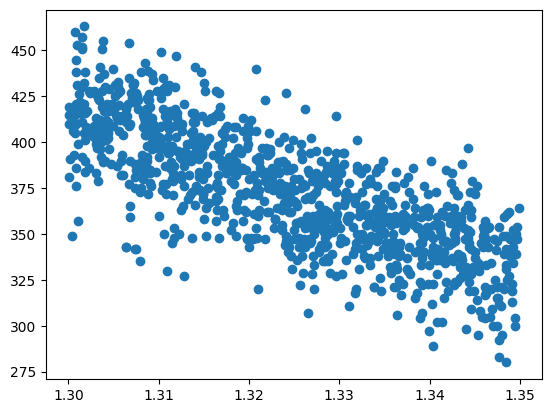

In [476]:
plt.scatter(sample2.log_mean_c2c_nn_dist, sample2.log_n_craters_added_in_study_region)

### MLE?

Can we use MLE to find the threshold value, as var(left) / var(right)?

In [505]:
# Var before and after a given point
left_point = 0.6
right_point = 1.4
dividing_point = 1.1
delta = 0.05
n_new_samples = 1000

sample1 = train.where(
    (train.log_mean_c2c_nn_dist.between(left_point, left_point + (right_point - left_point) / 2))
).withColumn(
    "rnd", F.rand()
).orderBy("rnd").limit(n_new_samples).toPandas()

sample2 = train.where(
    (train.log_mean_c2c_nn_dist.between(left_point + (right_point - left_point) / 2, right_point))
).withColumn(
    "rnd", F.rand()
).orderBy("rnd").limit(n_new_samples).toPandas()

sample1_detrended = detrend(sample1.log_n_craters_added_in_study_region, sample1.log_mean_c2c_nn_dist)
sample2_detrended = detrend(sample2.log_n_craters_added_in_study_region, sample2.log_mean_c2c_nn_dist)

In [506]:
print(f_test(sample1_detrended, sample2_detrended))
report(sample1_detrended)
report(sample2_detrended)

1.1102230246251565e-16
var=0.00409971822376715, skew=0.214, kurt=-0.295
var=0.0002616530356258298, skew=1.265, kurt=3.931


(array([  3.,   8.,  39., 103., 181., 125.,  31.,   4.,   4.,   2.]),
 array([-0.0680402 , -0.05292053, -0.03780085, -0.02268118, -0.0075615 ,
         0.00755817,  0.02267785,  0.03779752,  0.0529172 ,  0.06803687,
         0.08315655]),
 <BarContainer object of 10 artists>)

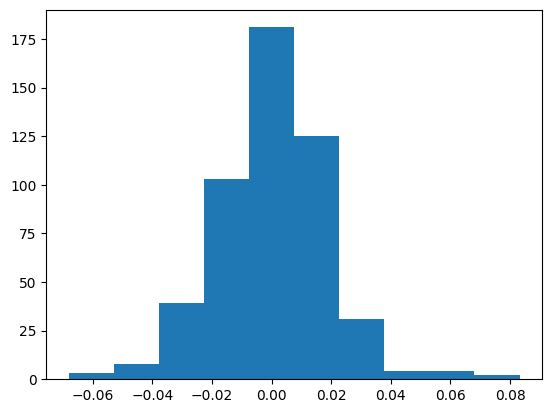

In [401]:
plt.hist(sample1_detrended)

(array([44., 45., 57., 56., 55., 42., 51., 49., 52., 49.]),
 array([-3.16685618e-04, -2.53683259e-04, -1.90680900e-04, -1.27678541e-04,
        -6.46761825e-05, -1.67382365e-06,  6.13285352e-05,  1.24330894e-04,
         1.87333253e-04,  2.50335612e-04,  3.13337971e-04]),
 <BarContainer object of 10 artists>)

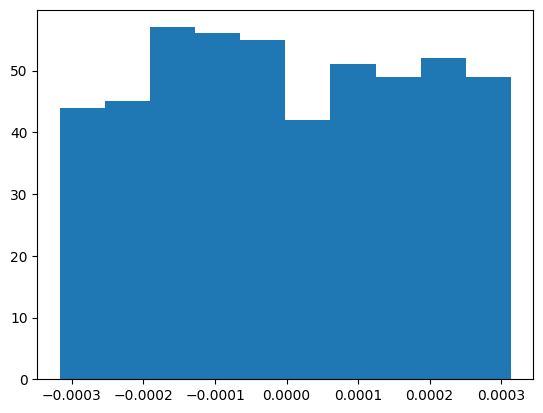

In [405]:
plt.hist(sample2_detrended)

In [308]:
sample1_detrended.shape

(500,)

In [309]:
sample2_detrended.shape

(500,)

(array([53., 50., 55., 48., 49., 46., 43., 49., 51., 56.]),
 array([-9.17512523e-05, -7.33461556e-05, -5.49410588e-05, -3.65359620e-05,
        -1.81308653e-05,  2.74231469e-07,  1.86793282e-05,  3.70844250e-05,
         5.54895217e-05,  7.38946185e-05,  9.22997153e-05]),
 <BarContainer object of 10 artists>)

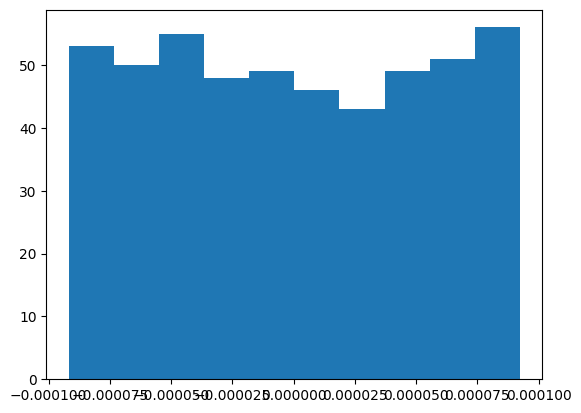

In [313]:
plt.hist(sample2_detrended)

In [311]:
stats.skew(sample1_detrended)

0.14802313098946285

In [263]:
f_test(np.random.normal(size=100000), np.random.normal(size=100000))

0.03525132249321561

In [248]:
np.random.normal(size=100)

array([-1.31602921,  0.50683433, -0.52273893, -0.62455   , -0.63495007,
       -1.822603  ,  0.33647501,  1.2070523 ,  0.86687524,  1.22102265,
        0.81288783,  0.82491152,  1.25894298,  1.76262613, -0.2977737 ,
       -0.98230709,  0.1590834 , -1.5439335 ,  0.56174159, -0.01618381,
       -0.55178307,  0.04211284, -0.24900204,  0.08527396,  0.57587149,
       -1.42694825, -0.37431883, -0.87920404, -0.4297704 , -0.01655033,
        0.47383179, -0.5905598 , -0.93332597,  0.02182266, -0.27540622,
        0.31035589,  0.69586488, -0.79825252,  0.78113733, -0.48589625,
       -0.03772046, -0.97900515, -0.45356198,  1.4287864 ,  1.48507069,
       -0.25276912,  0.60289277,  0.04953068, -0.29715367,  0.21392506,
        1.92374153,  0.57411224,  1.19904571,  1.52362029,  0.10767989,
       -2.04143466,  0.90979547, -0.26229982, -0.47496955, -0.34571441,
       -0.6235858 ,  0.40850118,  0.35355519,  0.05668959, -0.73844751,
       -0.16765055, -0.00669729,  1.88305237, -1.79273846,  1.78

In [221]:
p_value = 1 - stats.f.cdf(np.var(sample1_detrended) / np.var(sample2_detrended), sample1_detrended.shape[0] - 1, sample2_detrended.shape[0] - 1)
p_value

1.1102230246251565e-16

In [222]:
np.var(sample1_detrended)

0.0002253743964979454

In [223]:
np.var(sample2_detrended)

0.00013932903678182535

In [174]:
# model = sm.OLS(s1.log_n_craters_added_in_study_region,
#                sm.add_constant(s1.log_mean_c2c_nn_dist)).fit()

# pred = model.predict(sm.add_constant(s1.log_mean_c2c_nn_dist))
# s1["detrended"] = s1.log_n_craters_added_in_study_region - pred
# s1["pred"] = pred


In [200]:
s2 = train.where(
    (train.log_mean_c2c_nn_dist.between(1.2, 1.4))
).toPandas()

In [201]:
model = sm.OLS(s2.log_n_craters_added_in_study_region,
               sm.add_constant(s2.log_mean_c2c_nn_dist)).fit()

pred = model.predict(sm.add_constant(s2.log_mean_c2c_nn_dist))
s2["detrended"] = s2.log_n_craters_added_in_study_region - pred
s2["pred"] = pred

In [202]:
s1_detrended_outlier_removed = remove_outliers(s1.detrended)
s2_detrended_outlier_removed = remove_outliers(s2.detrended)
p_value = 1 - stats.f.cdf(np.var(s2_detrended_outlier_removed) / np.var(s1_detrended_outlier_removed), s2_detrended_outlier_removed.shape[0] - 1, s1_detrended_outlier_removed.shape[0] - 1)
p_value

1.1102230246251565e-16

In [191]:
stats.kurtosis(s2_detrended_outlier_removed)

-0.17222191553572053

In [190]:
stats.skew(s2_detrended_outlier_removed)

0.04294222936852123

(array([ 1324.,  3189.,  8189., 15232., 20983., 18726., 15066.,  7828.,
         3246.,  1469.]),
 array([-0.06278362, -0.05019318, -0.03760275, -0.02501232, -0.01242189,
         0.00016854,  0.01275898,  0.02534941,  0.03793984,  0.05053027,
         0.0631207 ]),
 <BarContainer object of 10 artists>)

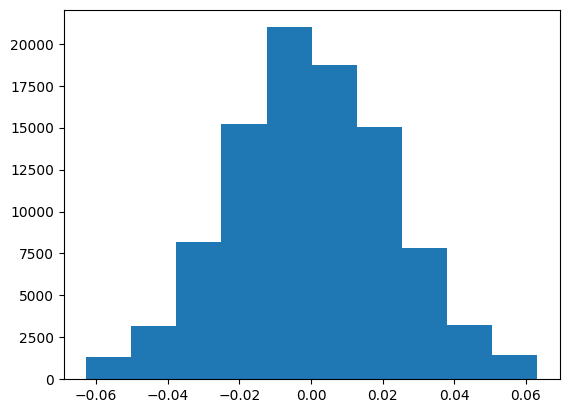

In [192]:
plt.hist(s2_detrended_outlier_removed)

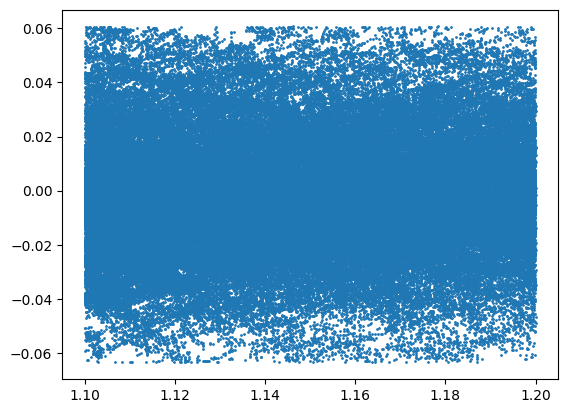

In [184]:
plt.scatter(s1.log_mean_c2c_nn_dist, s1.detrended_outlier_removed, s=1)

In [185]:
np.var(s1.detrended_outlier_removed)

0.0005105268735996482

In [186]:
np.var(s2.detrended_outlier_removed)

0.0005135320316945653

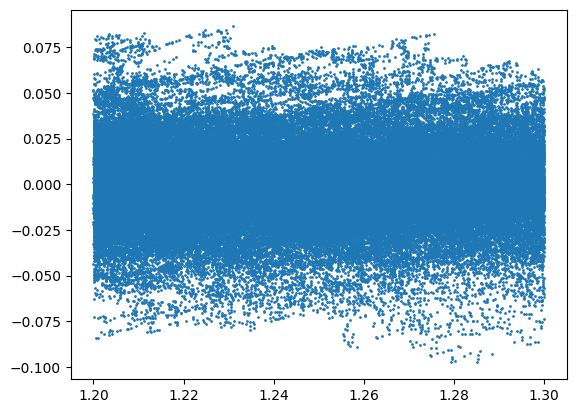

In [181]:
plt.scatter(s2.log_mean_c2c_nn_dist, s2.detrended, s=1)

In [167]:
stats.levene(s1.detrended, s2.detrended)

LeveneResult(statistic=276.25545469737574, pvalue=5.571234238748771e-62)

(array([  118.,   786.,  3192., 13672., 28716., 26846., 16451.,  4557.,
         1447.,   232.]),
 array([-0.09791474, -0.07871338, -0.05951202, -0.04031065, -0.02110929,
        -0.00190793,  0.01729344,  0.0364948 ,  0.05569616,  0.07489753,
         0.09409889]),
 <BarContainer object of 10 artists>)

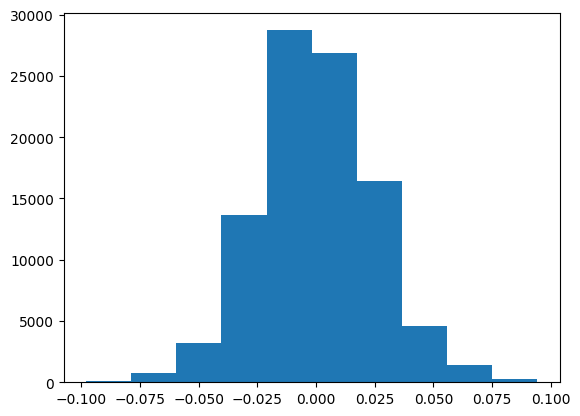

In [168]:
plt.hist(s1.detrended)

(array([   67.,   670.,  1478.,  4425., 10544., 16196., 14549.,  7068.,
         2237.,   169.]),
 array([-0.10603281, -0.08730034, -0.06856786, -0.04983539, -0.03110291,
        -0.01237044,  0.00636203,  0.02509451,  0.04382698,  0.06255946,
         0.08129193]),
 <BarContainer object of 10 artists>)

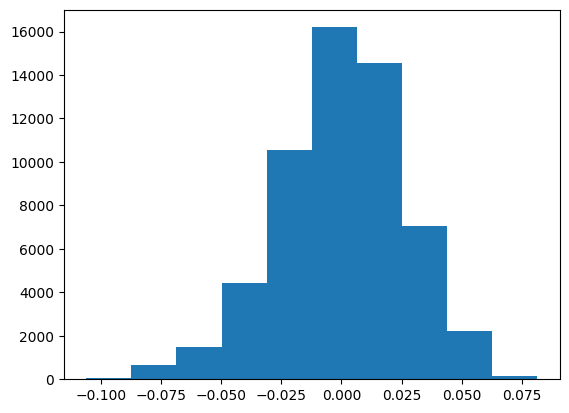

In [169]:
plt.hist(s2.detrended)

In [42]:
# Get all craters within some bandwidth using slope, log(NN_d), and log(A_d)
train_sample_fraction = 0.8
n_test_samples = 0

data_subset = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(50))
)

train, _ = setup_datasets_for_model(
    data_subset,
    configs_df,
    0.1,
    predictor_variables,
    target,
    train_sample_fraction,
    n_test_samples,
    spark,
    cache_train=False,
    cache_test=False
)
train = train.where(train.slope.between(2.1, 2.2)).cache()

In [44]:
# Sequential test
start = 1.4
end = 0.85
step = 0.025
n_samples = 300

pre_saturation = train.where(
    (train.log_mean_c2c_nn_dist.between(start - step, start))
).toPandas()

current = start - step
while current >= end:
    sample = train.where(
        (train.log_mean_c2c_nn_dist.between(current - step, current))
    ).toPandas().sort_values("log_mean_c2c_nn_dist")

    result = stats.levene(
        np.log10(pre_saturation.target),
        np.log10(sample.target)
    )

    t = sample.log_n_craters_added_in_study_region
    print(f"{current:.3f}, {result.pvalue:.2f}, {sample.shape[0]}, {t.quantile(0.975) - t.quantile(0.025):.3f}")
    
    current -= step

1.375, 0.00, 13275, 0.123
1.350, 0.00, 15350, 0.118
1.325, 0.00, 17778, 0.114
1.300, 0.00, 19711, 0.113
1.275, 0.00, 22529, 0.114
1.250, 0.00, 25302, 0.111
1.225, 0.00, 28993, 0.116
1.200, 0.00, 32898, 0.116
1.175, 0.00, 37045, 0.117
1.150, 0.00, 42506, 0.120
1.125, 0.37, 48724, 0.133
1.100, 0.00, 56286, 0.144
1.075, 0.00, 65607, 0.163
1.050, 0.00, 75870, 0.178
1.025, 0.00, 88619, 0.194
1.000, 0.00, 106456, 0.276
0.975, 0.00, 132588, 0.414
0.950, 0.00, 209205, 1.059
0.925, 0.00, 363338, 1.052
0.900, 0.00, 522966, 1.043
0.875, 0.00, 701884, 1.034
0.850, 0.00, 969467, 1.027


In [45]:
# Sequential test
start_slope = 1.5
end_slope = 1.6
start = 1.4
end = 0.85
step = 0.025

train, _ = setup_datasets_for_model(
    data_subset,
    configs_df,
    0.1,
    predictor_variables,
    target,
    train_sample_fraction,
    n_test_samples,
    spark,
    cache_train=False,
    cache_test=False
)
train = train.where(train.slope.between(start_slope, end_slope)).cache()

pre_saturation = train.where(
    (train.log_mean_c2c_nn_dist.between(start - step, start))
).toPandas()

current = start - step
while current >= end:
    sample = train.where(
        (train.log_mean_c2c_nn_dist.between(current - step, current))
    ).toPandas().sort_values("log_mean_c2c_nn_dist")

    result = stats.levene(
        np.log10(pre_saturation.target),
        np.log10(sample.target)
    )

    t = sample.log_n_craters_added_in_study_region
    print(f"{current:.3f}, {result.pvalue:.2f}, {sample.shape[0]}, {t.quantile(0.975) - t.quantile(0.025):.3f}")
    
    current -= step

1.375, 0.00, 15034, 0.160
1.350, 0.03, 17301, 0.172
1.325, 0.60, 20009, 0.178
1.300, 0.14, 23126, 0.181
1.275, 0.00, 26491, 0.206
1.250, 0.00, 30792, 0.223
1.225, 0.00, 35563, 0.237
1.200, 0.00, 40896, 0.257
1.175, 0.00, 49677, 0.324
1.150, 0.00, 59275, 0.418
1.125, 0.00, 75222, 0.647
1.100, 0.00, 97369, 0.677
1.075, 0.00, 126542, 0.746
1.050, 0.00, 182828, 0.801
1.025, 0.00, 287791, 0.829
1.000, 0.00, 423484, 0.840
0.975, 0.00, 561862, 0.842
0.950, 0.00, 694267, 0.808
0.925, 0.00, 791895, 0.797
0.900, 0.00, 815876, 0.779
0.875, 0.00, 765930, 0.756
0.850, 0.00, 810612, 0.734


In [ ]:
plt.hist(np.log10(pre_saturation1.target))

In [ ]:
plt.hist(np.log10(pre_saturation2.target))

In [ ]:
plt.hist(np.log10(pre_saturation3.target))

In [ ]:
plt.hist(np.log10(post_saturation1.target))

In [ ]:
plt.hist(np.log10(post_saturation2.target))

In [ ]:
# df = pre_saturation1
df = train.where(
    (train.slope.between(1.7, 1.75))
).toPandas()
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="slope",
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [ ]:
df

In [ ]:
df = train.where(
    train.log_mean_c2c_nn_dist.between(pre_start, pre_start + pre_step * 11)
).toPandas()
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="n_craters_added_in_study_region",
    color="n_craters_in_study_region",
    hover_data=[x for x in predictor_variables if x != "data.simulation_id"] + ["simulation_id"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [ ]:
df = post_saturation
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="target",
    color="slope",
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()